# Exploratory Data Analysis

In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### General analysis

In [3]:
df_train = pd.read_csv('data/aps_failure_training_set.csv')
df_train.drop('id', inplace=True, axis=1)
df_train.replace('na', np.nan, inplace=True)
df_train['class'].replace(['pos','neg'],[1,0], inplace=True)
df_train = df_train.astype(float)
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


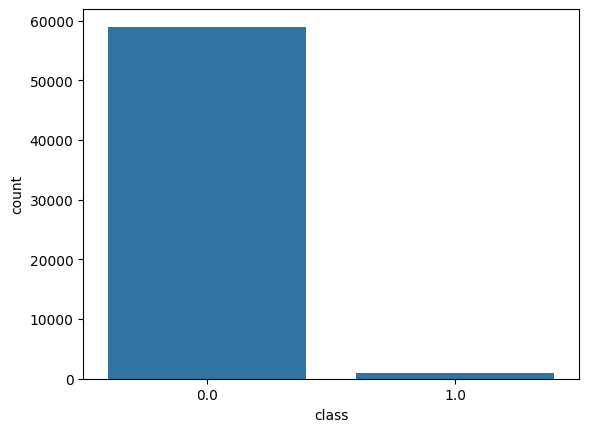

In [4]:
sns.barplot(df_train['class'].value_counts())  # highly imbalanced
plt.savefig('plots/class_distribution.png')

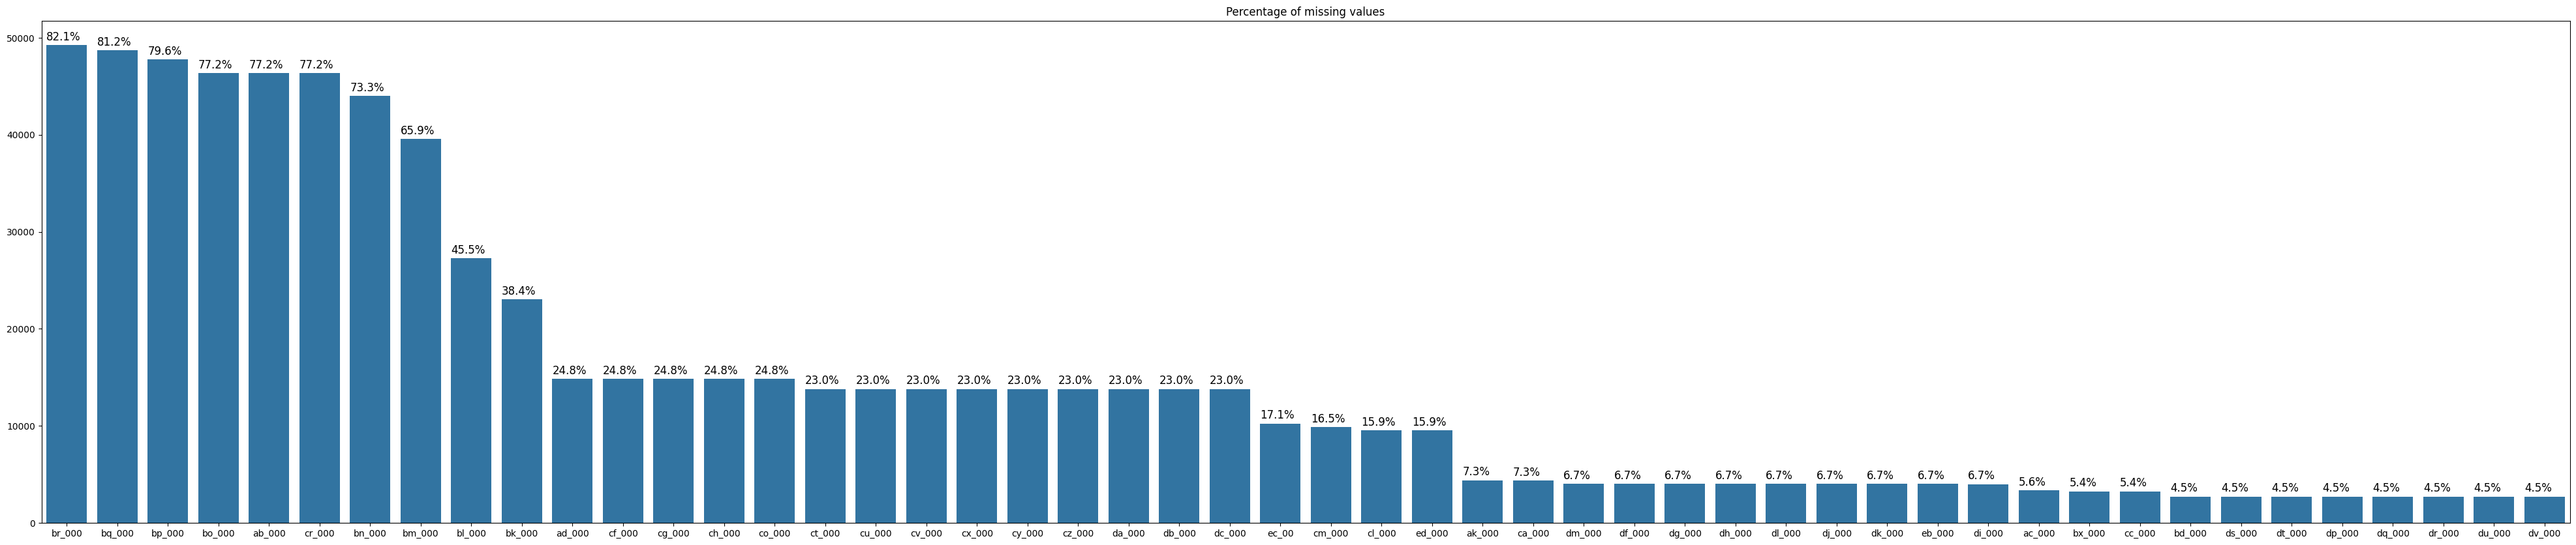

In [5]:
#https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot
def barplot(data,sum):
  plt.figure(figsize = (50,10))
  ax = sns.barplot(x = list(data.keys())[:50], y = list(data.values())[:50])

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/sum)
    x = p.get_x() 
    y = p.get_height()+500
    ax.set_title('Percentage of missing values')
    ax.annotate(percentage,(x,y),size=12)
  
missing_feature_count = dict(df_train.drop('class',axis=1).isnull().sum())
missing_feature_count = dict(sorted(missing_feature_count.items(), key=lambda item:item[1],reverse=True))
barplot(missing_feature_count, df_train.shape[0])
plt.savefig('plots/missing_feature_counts.png')


### Outlier detection

In [6]:
# doesnt work since it is not a normal distribution
# for col in df_train.columns:
#     q_low = df_train[col].quantile(0.0001)
#     q_hi  = df_train[col].quantile(0.9999)
#     v = df_train[(df_train[col] < q_hi) & (df_train[col] > q_low)].shape[0]
#     # if v != 0: print(v)

In [7]:
from sklearn.impute import SimpleImputer

X = df_train.drop('class', axis=1)

# apply simple impute to get rid of nan values
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
transformed_X = imp_median.fit_transform(X)

#### Local Outlier Factor

In [8]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(transformed_X)

outliers_local = [i for i in range(len(yhat)) if yhat[i] == -1]
print("Outliers found with LocalOutlierFactor:", len(outliers_local))

Outliers found with LocalOutlierFactor: 3179


#### Isolation Forest

In [9]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0)
yhat = clf.fit_predict(transformed_X)

outliers_forest = [i for i in range(len(yhat)) if yhat[i] == -1]
print("Outliers found with Isolation Forest:", len(outliers_forest))

Outliers found with Isolation Forest: 2765


In [10]:
print('Points found with both:', len(np.intersect1d(outliers_forest, outliers_local)))

Points found with both: 291


### Feature vs. target relationships

Top 5 features correlated:
 ci_000    0.553308
bb_000    0.542744
bv_000    0.541598
bu_000    0.541598
cq_000    0.541598
dtype: float64


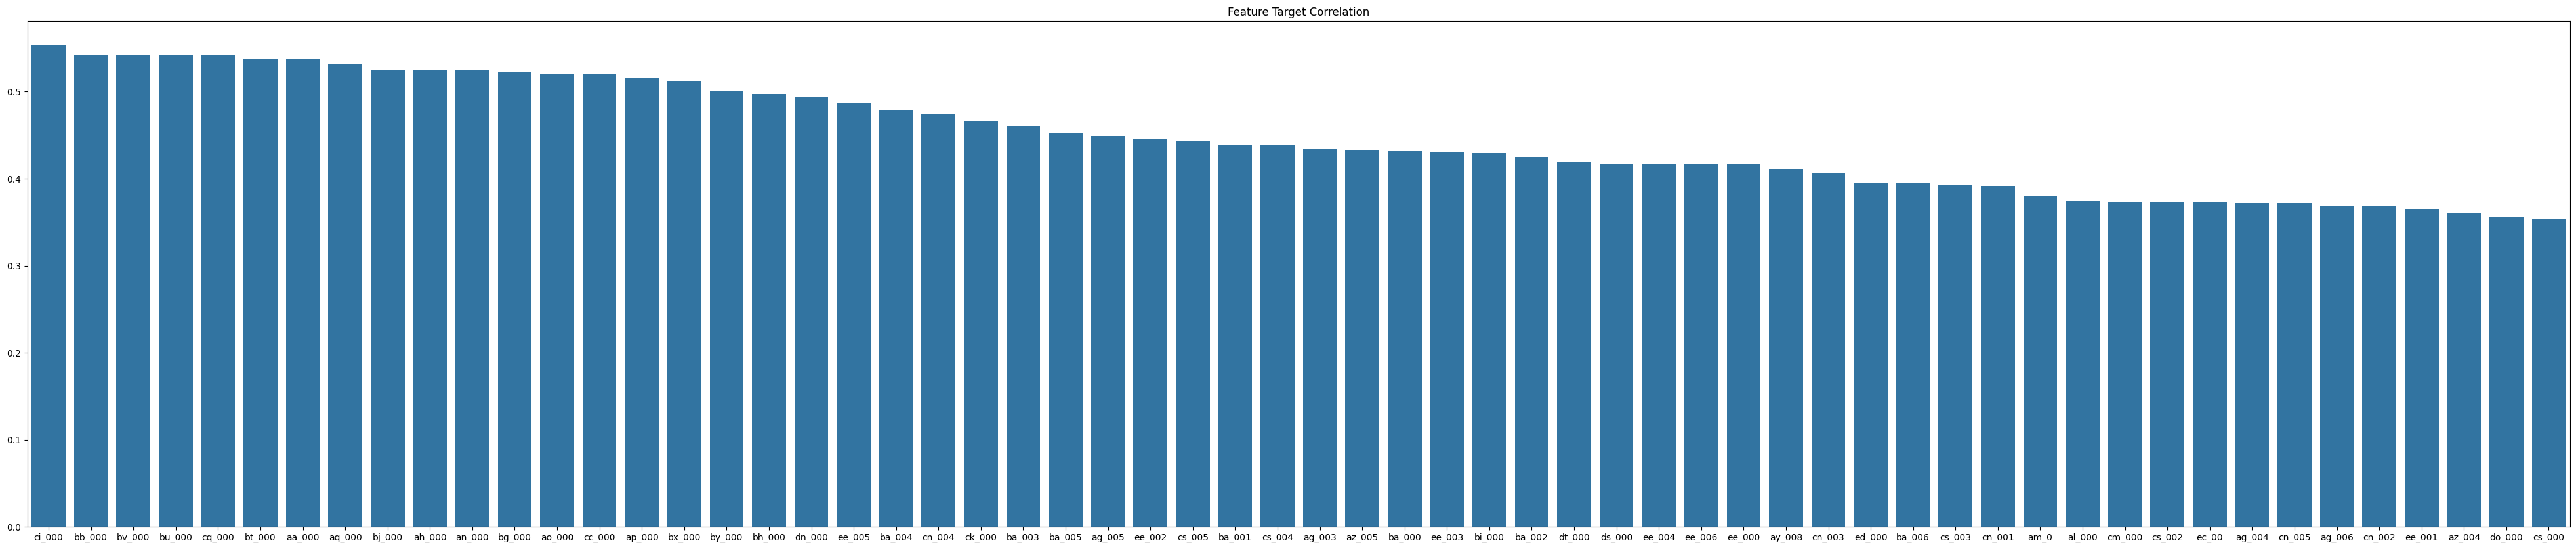

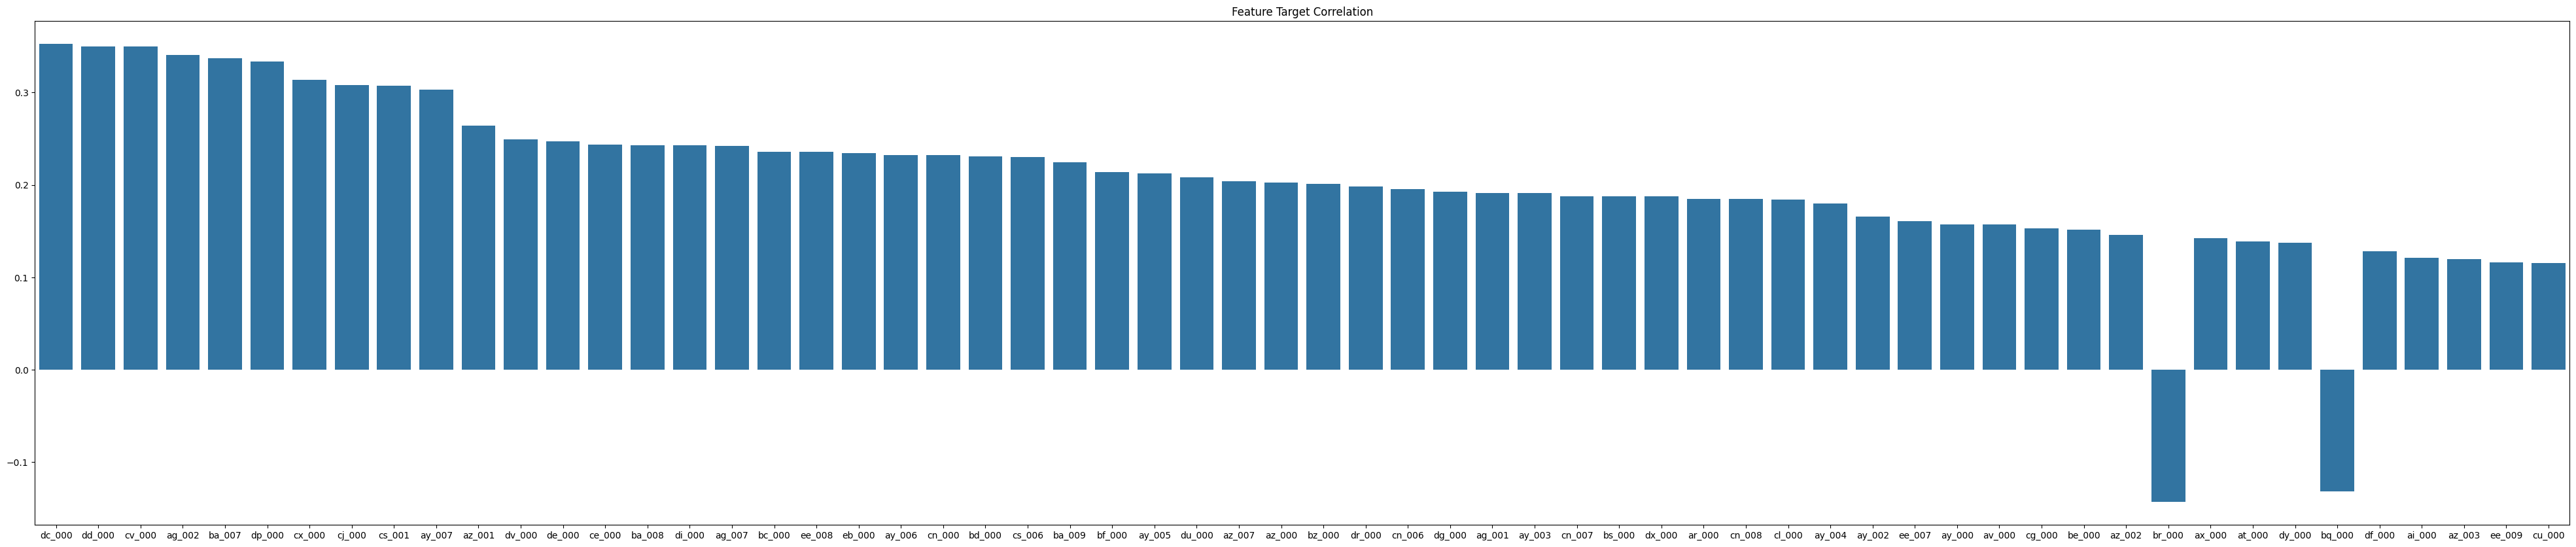

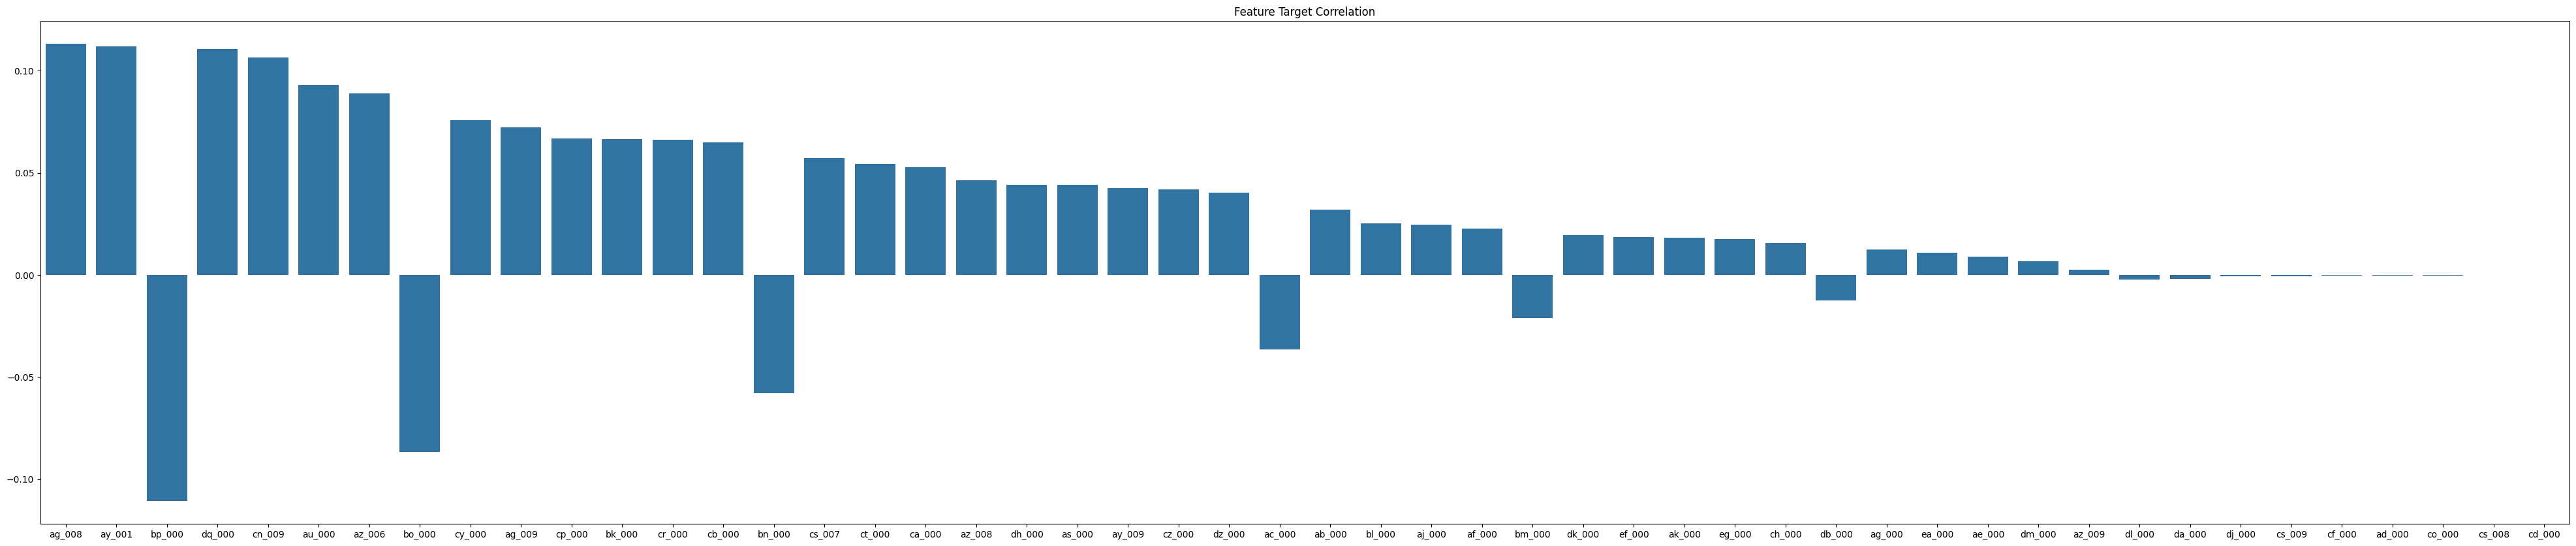

In [11]:
corr = X.apply(lambda x: x.corr(df_train['class']))
corr = corr.sort_values(key=lambda x: abs(x), ascending=False)
print('Top 5 features correlated:\n', corr[:5])

for i in range(0, 180, 60):
  plt.figure(figsize = (50,10))
  ax = sns.barplot(x=list(corr.keys())[i:i+60], y=list(corr.values)[i:i+60]).set_title('Feature Target Correlation')
  plt.savefig(f'plots/target-feature-relationship{i}.png')

### Correlation Analysis

In [28]:
df_x = pd.DataFrame(transformed_X)
out = df_x.loc[:,df_x.nunique()!=1]  # drop columns with zero variance

def scatter_coefficient(X, normalize=True):
    corr = np.corrcoef(X, rowvar=False)
    if normalize:
        return np.linalg.det(corr) / np.trace(corr)
    else:
        return np.linalg.det(corr)
    
print("Correlation of the features:", scatter_coefficient(out))

Correlation of the features: 1.702817572377432e-173
